In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

#load the preprocessed data
X_train = pd.read_csv("X_train_multi.csv")
X_test = pd.read_csv("X_test_multi.csv")
y_train = pd.read_csv("y_train_multi.csv").squeeze()
y_test = pd.read_csv("y_test_multi.csv").squeeze()

num_classes = 11

In [3]:
#define the hyperparameter distributions
params = {
    'max_depth': stats.randint(2, 30),
    'learning_rate': stats.uniform(0.01, 0.3),
    'subsample': stats.uniform(0.05, 0.8),
    'n_estimators':stats.randint(50, 1500)
}

#create the XGBoost model
xgb_model = xgb.XGBClassifier(
    device='cuda',  # keep using GPU if available
    objective='multi:softmax',
    num_class=num_classes,
    random_state=42
)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=20, cv=8, scoring='recall_macro', verbose=1, random_state=42)

#conduct the hyperparameter search
random_search.fit(X_train, y_train)

Fitting 8 folds for each of 20 candidates, totalling 160 fits


RandomizedSearchCV(cv=8,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constra...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000015FAB28F9D0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015FAB28FC50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015F2BB46C40>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000015F2BB46D70>},
                   random_state=42, scoring='recall_macro', verbose=1)

In [5]:
#print best parameters
print("Best set of hyperparameters: ", random_search.best_params_)

Best set of hyperparameters:  {'learning_rate': np.float64(0.29156581270472504), 'max_depth': 3, 'n_estimators': 1265, 'subsample': np.float64(0.8437692474329741)}


In [6]:
search_alg = random_search

#predict on the test set
y_pred = search_alg.best_estimator_.predict(X_test)

In [7]:
#calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9999584945659808
Recall: 0.9754753875568057
Precision: 0.9928079436352177
F1 Score: 0.9821302676105707


In [8]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242754
           1       1.00      1.00      1.00      9676
           2       1.00      1.00      1.00      9331
           3       1.00      1.00      1.00     34296
           4       1.00      1.00      1.00     14377
           5       1.00      1.00      1.00      2094
           6       1.00      1.00      1.00       558
           7       0.99      1.00      0.99        83
           8       1.00      0.73      0.84        26
           9       0.93      1.00      0.97        14
          10       1.00      1.00      1.00         3

    accuracy                           1.00    313212
   macro avg       0.99      0.98      0.98    313212
weighted avg       1.00      1.00      1.00    313212



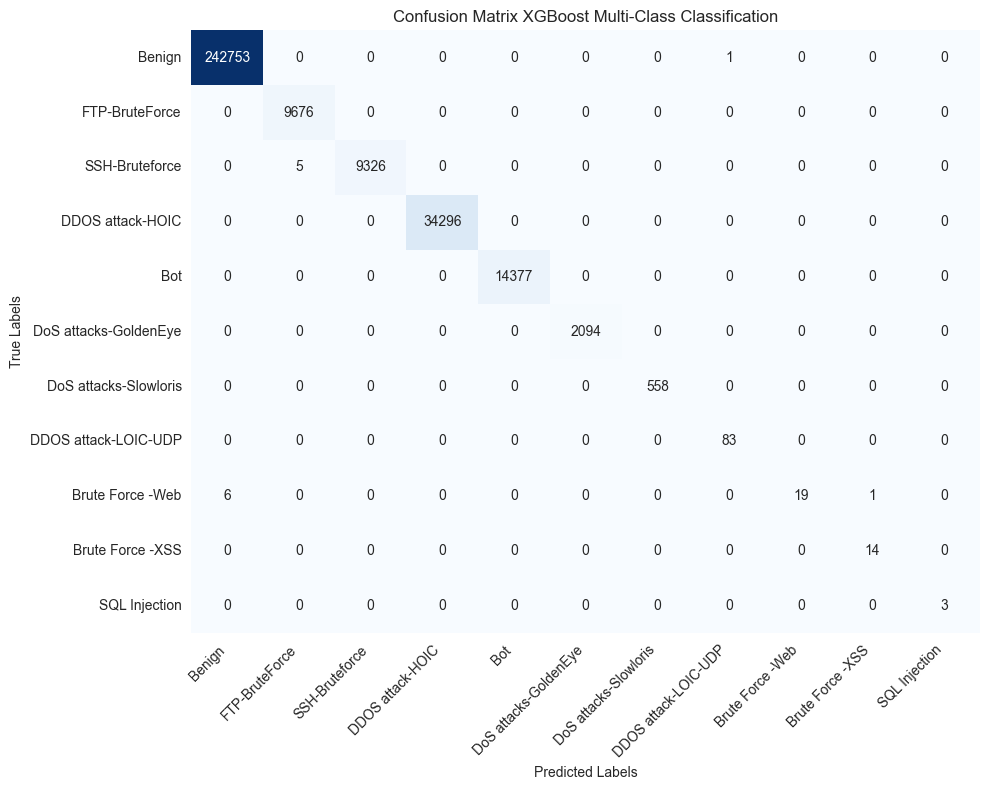

In [9]:
labels = [
    'Benign',
    'FTP-BruteForce',
    'SSH-Bruteforce',
    'DDOS attack-HOIC',
    'Bot',
    'DoS attacks-GoldenEye',
    'DoS attacks-Slowloris',
    'DDOS attack-LOIC-UDP',
    'Brute Force -Web',
    'Brute Force -XSS',
    'SQL Injection'
]

# Compute confusion matrix with string labels
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost Multi-Class Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()